In [1]:
import torch

if torch.cuda.is_available():
    print("CUDA está disponível!")
    print(f"Nome da GPU: {torch.cuda.get_device_name(0)}")
    print(f"Número de GPUs disponíveis: {torch.cuda.device_count()}")
else:
    print("CUDA NÃO está disponível. O notebook está rodando em CPU ou o tipo de ambiente de execução não foi configurado para GPU.")

CUDA NÃO está disponível. O notebook está rodando em CPU ou o tipo de ambiente de execução não foi configurado para GPU.


In [2]:
!pip install shap -q

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm
import statsmodels.formula.api as smf
import shap

In [4]:
df = pd.read_csv('/content/base_integrada_leptospirose_2008-2023.csv', sep=';')
df.head()

,MES,ESTADO,CASOS,ANO,TEMPERATURA,UMIDADE,PRECIPITACAO
0,Janeiro,RO,0,2010,26.944762,75.233333,11.4
1,Fevereiro,RO,0,2010,27.046957,77.643478,71.8
2,Marco,RO,2,2010,26.889224,78.741379,37.8
3,Abril,RO,1,2010,26.369231,79.226496,66.8
4,Maio,RO,3,2010,26.616087,78.217391,67.4


# MODELO GLM PARA CONTAGEM DE CASOS

In [5]:
# Modelo Poisson inicial
m_pois = smf.glm(
    formula='CASOS ~ TEMPERATURA + UMIDADE + PRECIPITACAO + ESTADO + ANO',
    data=df,
    family=sm.families.Poisson(link=sm.families.links.Log())
).fit()

# Ver o resumo do modelo
print("=== MODELO POISSON ===")
print(m_pois.summary())

# Informações adicionais
print(f"\nAIC: {m_pois.aic:.2f}")
print(f"Deviance: {m_pois.deviance:.2f}")
print(f"Pearson chi2: {m_pois.pearson_chi2:.2f}")

=== MODELO POISSON ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  CASOS   No. Observations:                 4716
Model:                            GLM   Df Residuals:                     4687
Model Family:                 Poisson   Df Model:                           28
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15099.
Date:                Thu, 27 Nov 2025   Deviance:                       19752.
Time:                        17:29:03   Pearson chi2:                 2.93e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9927
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       59.7343  

In [6]:
# Checagem de superdispersão
residuos_pearson = m_pois.resid_pearson
disp = (residuos_pearson ** 2).sum() / m_pois.df_resid

print("=== CHECAGEM DE SUPERDISPERSÃO ===")
print(f"Parâmetro de dispersão: {disp:.4f}")
print(f"Graus de liberdade residuais: {m_pois.df_resid}")
print(f"\nInterpretação:")
if disp > 1.5:
    print(f"    Dispersão = {disp:.2f} > 1.5 → SUPERDISPERSÃO detectada!")
    print("  → Modelo Poisson pode não ser adequado.")
    print("  → Considere usar Binomial Negativa.")
else:
    print(f"  ✓ Dispersão = {disp:.2f} ≤ 1.5 → Poisson adequado.")

=== CHECAGEM DE SUPERDISPERSÃO ===
Parâmetro de dispersão: 6.2536
Graus de liberdade residuais: 4687

Interpretação:
    Dispersão = 6.25 > 1.5 → SUPERDISPERSÃO detectada!
  → Modelo Poisson pode não ser adequado.
  → Considere usar Binomial Negativa.


In [7]:
# Modelo Binomial Negativo
# Precisamos usar GLM do statsmodels com família NegativeBinomial

# Preparar dados (remover NAs)
vars_modelo = ['CASOS', 'TEMPERATURA', 'UMIDADE', 'PRECIPITACAO', 'ESTADO', 'ANO']
df_modelo = df[vars_modelo].dropna()

# Modelo usando fórmula (mais fácil)
m_nb = smf.glm(
    formula='CASOS ~ TEMPERATURA + UMIDADE + PRECIPITACAO + ESTADO + ANO',
    data=df_modelo,
    family=sm.families.NegativeBinomial()
).fit()

print("=== MODELO BINOMIAL NEGATIVO ===")
print(m_nb.summary())

# Informações importantes
print(f"\nAIC: {m_nb.aic:.2f}")
print(f"Theta (parâmetro de dispersão): {m_nb.scale:.4f}")

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


=== MODELO BINOMIAL NEGATIVO ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  CASOS   No. Observations:                 4716
Model:                            GLM   Df Residuals:                     4687
Model Family:        NegativeBinomial   Df Model:                           28
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9974.5
Date:                Thu, 27 Nov 2025   Deviance:                       3857.0
Time:                        17:29:06   Pearson chi2:                 5.28e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.6197
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      

In [8]:
# Calcular IRR (Incidence Rate Ratios) = exp(coeficientes)
# Equivalente ao exponentiate = TRUE
# Extrair coeficientes, IC e p-valores
irr = pd.DataFrame({
    'term': m_nb.params.index,
    'estimate': np.exp(m_nb.params.values),  # IRR = exp(coef)
    'conf.low': np.exp(m_nb.conf_int()[0].values),  # IC inferior
    'conf.high': np.exp(m_nb.conf_int()[1].values),  # IC superior
    'std.error': m_nb.bse.values,
    'statistic': m_nb.tvalues.values,
    'p.value': m_nb.pvalues.values
})

# Mostrar todos os resultados
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("=== INCIDENCE RATE RATIOS (IRR) ===")
print(irr.to_string(index=False))

# Interpretação dos IRRs principais
print("\n=== INTERPRETAÇÃO (variáveis contínuas) ===")
for var in ['TEMPERATURA', 'UMIDADE', 'PRECIPITACAO']:
    if var in irr['term'].values:
        irr_val = irr[irr['term'] == var]['estimate'].values[0]
        p_val = irr[irr['term'] == var]['p.value'].values[0]
        sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
        mudanca = (irr_val - 1) * 100
        print(f"{var}: IRR = {irr_val:.4f} → {mudanca:+.2f}% por unidade {sig}")

=== INCIDENCE RATE RATIOS (IRR) ===
        term     estimate     conf.low    conf.high  std.error  statistic       p.value
   Intercept 3.423910e+29 4.126689e+22 2.840815e+36   8.128416   8.366421  5.939491e-17
ESTADO[T.AL] 2.462246e-01 1.973773e-01 3.071607e-01   0.112822 -12.422322  1.977389e-35
ESTADO[T.AM] 2.568227e-01 1.984417e-01 3.323791e-01   0.131579 -10.331188  5.092602e-25
ESTADO[T.BA] 3.853866e-01 3.110695e-01 4.774587e-01   0.109303  -8.723505  2.697196e-18
ESTADO[T.CE] 2.779631e-01 2.179392e-01 3.545185e-01   0.124121 -10.314688  6.047764e-25
ESTADO[T.DF] 1.768931e-01 1.192758e-01 2.623428e-01   0.201079  -8.614592  7.019137e-18
ESTADO[T.ES] 9.170909e-02 7.117019e-02 1.181753e-01   0.129363 -18.468398  3.709279e-76
ESTADO[T.GO] 6.455065e-02 4.606029e-02 9.046374e-02   0.172197 -15.913825  5.081180e-57
ESTADO[T.MA] 9.071352e-02 7.053273e-02 1.166684e-01   0.128385 -18.694185  5.520725e-78
ESTADO[T.MG] 2.093047e-01 1.445922e-01 3.029794e-01   0.188715  -8.287461  1.156920e

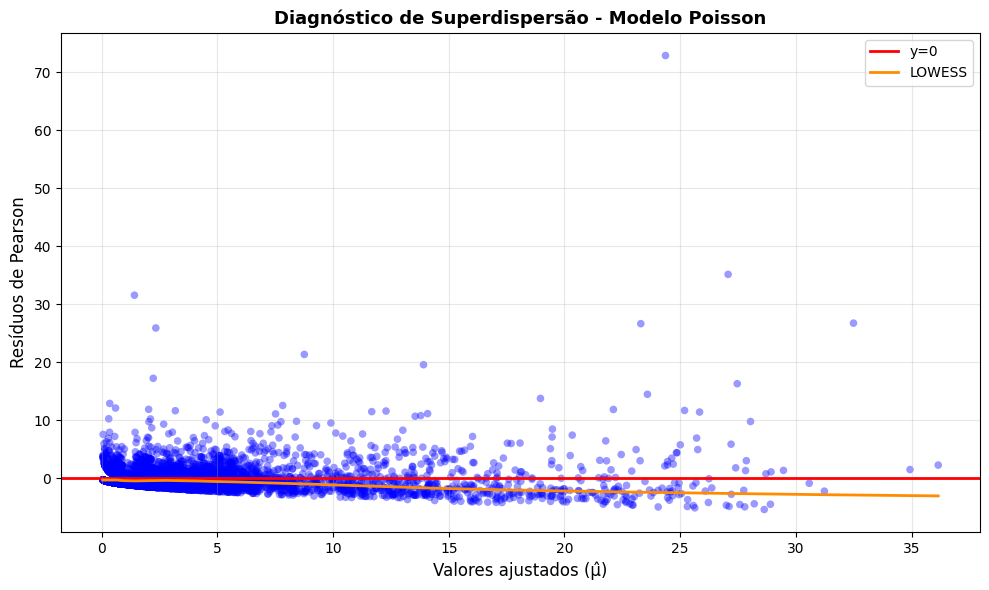

In [9]:
# Criar dataframe de diagnóstico
diag_df = pd.DataFrame({
    'Ajustado': m_pois.fittedvalues,
    'Residuos': m_pois.resid_pearson
})

# Gráfico de diagnóstico
plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(diag_df['Ajustado'], diag_df['Residuos'],
           alpha=0.4, s=30, color='blue', edgecolors='none')

# Linha horizontal em zero
plt.axhline(y=0, color='red', linewidth=2, label='y=0')

# LOWESS (suavização)
from statsmodels.nonparametric.smoothers_lowess import lowess
smoothed = lowess(diag_df['Residuos'], diag_df['Ajustado'], frac=0.3)
plt.plot(smoothed[:, 0], smoothed[:, 1],
        color='darkorange', linewidth=2, label='LOWESS')

# Formatação
plt.xlabel('Valores ajustados (μ̂)', fontsize=12)
plt.ylabel('Resíduos de Pearson', fontsize=12)
plt.title('Diagnóstico de Superdispersão - Modelo Poisson', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

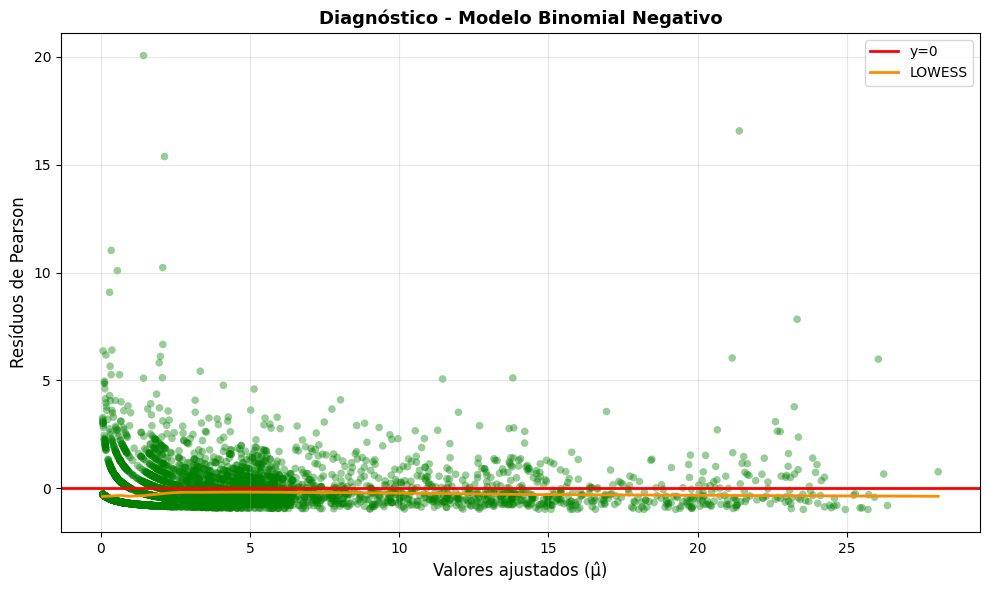

In [10]:
# Criar dataframe de diagnóstico para Binomial Negativo
diag_nb = pd.DataFrame({
    'Ajustado': m_nb.fittedvalues,
    'Residuos': m_nb.resid_pearson
})

# Gráfico de diagnóstico
plt.figure(figsize=(10, 6))

# Scatter plot (verde para diferenciar do Poisson)
plt.scatter(diag_nb['Ajustado'], diag_nb['Residuos'],
           alpha=0.4, s=30, color='green', edgecolors='none')

# Linha horizontal em zero
plt.axhline(y=0, color='red', linewidth=2, label='y=0')

# LOWESS (suavização)
smoothed = lowess(diag_nb['Residuos'], diag_nb['Ajustado'], frac=0.3)
plt.plot(smoothed[:, 0], smoothed[:, 1],
        color='darkorange', linewidth=2, label='LOWESS')

# Formatação
plt.xlabel('Valores ajustados (μ̂)', fontsize=12)
plt.ylabel('Resíduos de Pearson', fontsize=12)
plt.title('Diagnóstico - Modelo Binomial Negativo', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
# Função de dispersão
def dispersion(model):
    return (model.resid_pearson ** 2).sum() / model.df_resid

# Calcular dispersão de cada modelo
disp_pois = dispersion(m_pois)
disp_nb = dispersion(m_nb)

# Criar tabela de comparação
comparacao = pd.DataFrame({
    'Modelo': ['Poisson', 'NegBin'],
    'AIC': [m_pois.aic, m_nb.aic],
    'Dispersao': [disp_pois, disp_nb],
    'Theta_NegBin': [np.nan, m_nb.scale]  # theta é armazenado em scale
})

print("=== COMPARAÇÃO DOS MODELOS ===")
print(comparacao.to_string(index=False))

# Interpretação
print("\n=== INTERPRETAÇÃO ===")
print(f"Diferença de AIC: {m_pois.aic - m_nb.aic:.2f}")
if m_nb.aic < m_pois.aic:
    diff = m_pois.aic - m_nb.aic
    print(f"✓ Binomial Negativo é melhor (ΔAIC = {diff:.2f})")
else:
    print("✓ Poisson é melhor")

print(f"\nRedução na dispersão: {disp_pois:.2f} → {disp_nb:.2f}")

=== COMPARAÇÃO DOS MODELOS ===
 Modelo          AIC  Dispersao  Theta_NegBin
Poisson 30256.523317   6.253639           NaN
 NegBin 20006.968172   1.127405           1.0

=== INTERPRETAÇÃO ===
Diferença de AIC: 10249.56
✓ Binomial Negativo é melhor (ΔAIC = 10249.56)

Redução na dispersão: 6.25 → 1.13


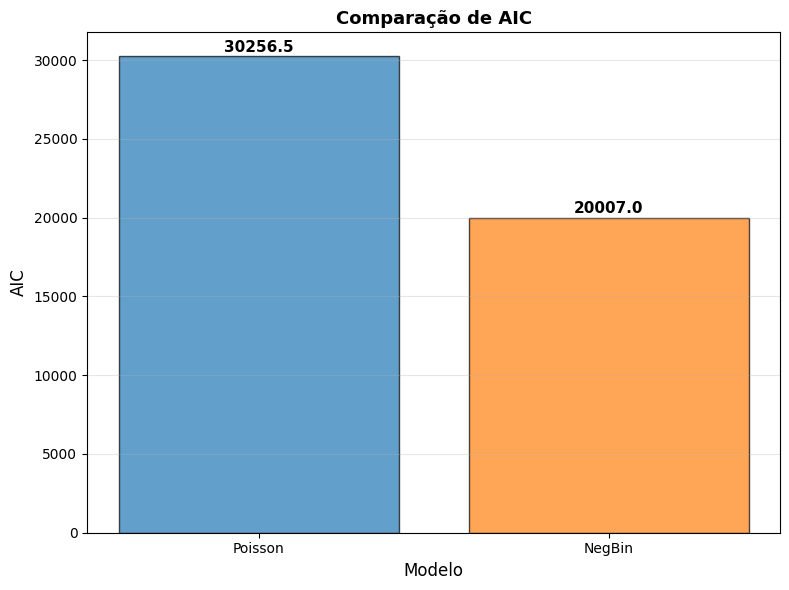

In [12]:
# Gráfico de comparação de AIC
plt.figure(figsize=(8, 6))

plt.bar(comparacao['Modelo'], comparacao['AIC'],
        color=['#1f77b4', '#ff7f0e'], alpha=0.7, edgecolor='black')

plt.title('Comparação de AIC', fontsize=13, fontweight='bold')
plt.ylabel('AIC', fontsize=12)
plt.xlabel('Modelo', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

# Adicionar valores em cima das barras
for i, (modelo, aic) in enumerate(zip(comparacao['Modelo'], comparacao['AIC'])):
    plt.text(i, aic + 100, f'{aic:.1f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

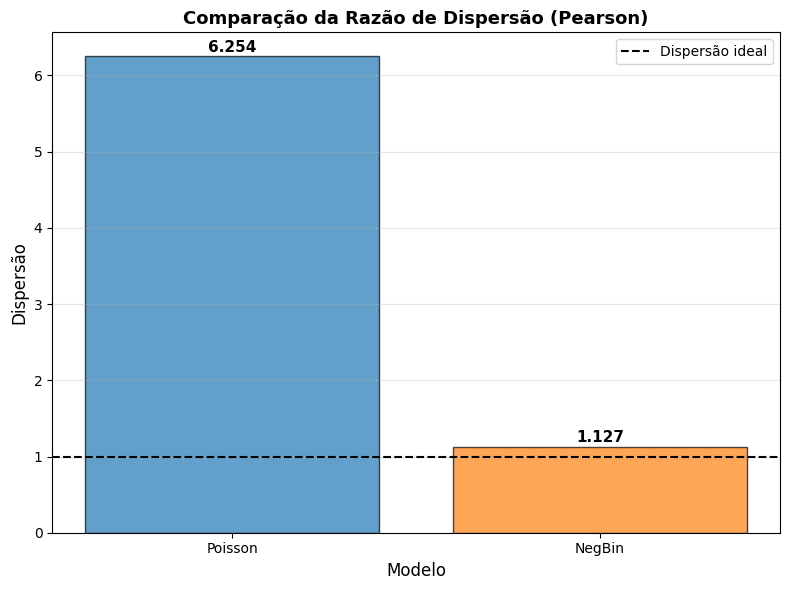

In [13]:
# Gráfico de comparação de Dispersão
plt.figure(figsize=(8, 6))

plt.bar(comparacao['Modelo'], comparacao['Dispersao'],
        color=['#1f77b4', '#ff7f0e'], alpha=0.7, edgecolor='black')

# Linha horizontal em y=1 (referência)
plt.axhline(y=1, color='black', linestyle='--', linewidth=1.5, label='Dispersão ideal')

plt.title('Comparação da Razão de Dispersão (Pearson)', fontsize=13, fontweight='bold')
plt.ylabel('Dispersão', fontsize=12)
plt.xlabel('Modelo', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Adicionar valores em cima das barras
for i, (modelo, disp) in enumerate(zip(comparacao['Modelo'], comparacao['Dispersao'])):
    plt.text(i, disp + 0.02, f'{disp:.3f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

In [14]:
# Preparar dados sem NA
vars_modelo = ['CASOS', 'TEMPERATURA', 'UMIDADE', 'PRECIPITACAO', 'ESTADO', 'ANO']
dados_sem_na = df[vars_modelo].dropna()

print(f"Dados originais: {len(df)}")
print(f"Dados sem NA: {len(dados_sem_na)}")

# Modelo Binomial Negativo completo
modelo_filtrado = smf.glm(
    formula='CASOS ~ TEMPERATURA + UMIDADE + PRECIPITACAO + ESTADO + ANO',
    data=dados_sem_na,
    family=sm.families.NegativeBinomial()
).fit()

print("\n=== MODELO COMPLETO ===")
print(f"AIC inicial: {modelo_filtrado.aic:.2f}")

# Seleção stepwise (backward)
# Statsmodels não tem stepAIC nativo, vamos implementar manualmente
def stepwise_selection(data, response, initial_features, threshold_out=0.05):
    """
    Seleção backward stepwise baseada em AIC
    """
    included = list(initial_features)
    best_aic = float('inf')

    print("\n=== SELEÇÃO STEPWISE (Backward) ===")

    while True:
        changed = False

        # Modelo atual
        formula = f"{response} ~ " + " + ".join(included)
        current_model = smf.glm(formula, data=data,
                                family=sm.families.NegativeBinomial()).fit()
        current_aic = current_model.aic

        print(f"\nModelo atual: {formula}")
        print(f"AIC: {current_aic:.2f}")

        # Testar remoção de cada variável
        best_new_aic = current_aic
        worst_feature = None

        for feature in included:
            # Criar modelo sem essa feature
            features_temp = [f for f in included if f != feature]
            if len(features_temp) == 0:
                continue

            formula_temp = f"{response} ~ " + " + ".join(features_temp)
            try:
                model_temp = smf.glm(formula_temp, data=data,
                                    family=sm.families.NegativeBinomial()).fit()

                if model_temp.aic < best_new_aic:
                    best_new_aic = model_temp.aic
                    worst_feature = feature
            except:
                continue

        # Se encontrou melhoria, remove a variável
        if worst_feature and best_new_aic < current_aic:
            print(f"  - Removendo: {worst_feature} (ΔAIC = {current_aic - best_new_aic:.2f})")
            included.remove(worst_feature)
            changed = True

        if not changed:
            break

    return current_model, included

# Executar seleção stepwise
initial_features = ['TEMPERATURA', 'UMIDADE', 'PRECIPITACAO', 'ESTADO', 'ANO']
modelo_step, selected_features = stepwise_selection(
    dados_sem_na, 'CASOS', initial_features
)

print("\n=== MODELO FINAL (após stepwise) ===")
print(f"Variáveis selecionadas: {', '.join(selected_features)}")
print(f"AIC final: {modelo_step.aic:.2f}")
print(f"\n{modelo_step.summary()}")

Dados originais: 4800
Dados sem NA: 4716

=== MODELO COMPLETO ===
AIC inicial: 20006.97

=== SELEÇÃO STEPWISE (Backward) ===

Modelo atual: CASOS ~ TEMPERATURA + UMIDADE + PRECIPITACAO + ESTADO + ANO
AIC: 20006.97


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha no

  - Removendo: TEMPERATURA (ΔAIC = 1.88)

Modelo atual: CASOS ~ UMIDADE + PRECIPITACAO + ESTADO + ANO
AIC: 20005.09


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha no

  - Removendo: PRECIPITACAO (ΔAIC = 1.65)

Modelo atual: CASOS ~ UMIDADE + ESTADO + ANO
AIC: 20003.44

=== MODELO FINAL (após stepwise) ===
Variáveis selecionadas: UMIDADE, ESTADO, ANO
AIC final: 20003.44

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  CASOS   No. Observations:                 4716
Model:                            GLM   Df Residuals:                     4689
Model Family:        NegativeBinomial   Df Model:                           26
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9974.7
Date:                Thu, 27 Nov 2025   Deviance:                       3857.5
Time:                        17:29:27   Pearson chi2:                 5.28e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.6197
Covariance Type:            nonrobust                                         
    

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [15]:
# Ver resumo do modelo final após stepwise
print("=== RESUMO DO MODELO FINAL (stepwise) ===")
print(modelo_step.summary())

# Informações adicionais
print(f"\n=== INFORMAÇÕES ADICIONAIS ===")
print(f"AIC: {modelo_step.aic:.2f}")
print(f"BIC: {modelo_step.bic:.2f}")
print(f"Deviance: {modelo_step.deviance:.2f}")
print(f"Dispersão: {dispersion(modelo_step):.4f}")
print(f"Variáveis no modelo: {', '.join(selected_features)}")

=== RESUMO DO MODELO FINAL (stepwise) ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  CASOS   No. Observations:                 4716
Model:                            GLM   Df Residuals:                     4689
Model Family:        NegativeBinomial   Df Model:                           26
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9974.7
Date:                Thu, 27 Nov 2025   Deviance:                       3857.5
Time:                        17:29:29   Pearson chi2:                 5.28e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.6197
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Interc

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


# SHAP

In [16]:
print("="*70)
print(" ANÁLISE SHAP - MODELO COMPLETO")
print("="*70)

print("\n=== PREPARANDO DADOS COM TARGET ENCODING ===\n")

features_completo = ['TEMPERATURA', 'UMIDADE', 'PRECIPITACAO', 'ESTADO', 'ANO']
X_shap_completo = dados_sem_na[features_completo].copy()

# Target Encoding: substituir ESTADO pela média de casos por estado
estado_means = dados_sem_na.groupby('ESTADO')['CASOS'].mean().to_dict()
X_shap_completo['ESTADO_encoded'] = X_shap_completo['ESTADO'].map(estado_means)

# Criar X numérico
X_numeric_completo = X_shap_completo[['TEMPERATURA', 'UMIDADE', 'PRECIPITACAO', 'ESTADO_encoded', 'ANO']]

print(f"Shape dos dados: {X_numeric_completo.shape}")
print(f"Colunas: {list(X_numeric_completo.columns)}")
print(f"\nTarget encoding de ESTADO (médias de casos):")
for estado, media in sorted(estado_means.items())[:10]:
    print(f"  {estado}: {media:.2f} casos em média")

 ANÁLISE SHAP - MODELO COMPLETO

=== PREPARANDO DADOS COM TARGET ENCODING ===

Shape dos dados: (4716, 5)
Colunas: ['TEMPERATURA', 'UMIDADE', 'PRECIPITACAO', 'ESTADO_encoded', 'ANO']

Target encoding de ESTADO (médias de casos):
  AC: 19.12 casos em média
  AL: 4.42 casos em média
  AM: 4.05 casos em média
  BA: 6.62 casos em média
  CE: 3.90 casos em média
  DF: 1.93 casos em média
  ES: 1.52 casos em média
  GO: 0.69 casos em média
  MA: 1.84 casos em média
  MG: 2.24 casos em média


In [17]:
def model_predict_completo(X_input):
    """
    Função para predição - precisa reverter o target encoding
    """
    X_df = pd.DataFrame(X_input, columns=X_numeric_completo.columns)

    # Reverter target encoding: encontrar o estado mais próximo
    estados = []
    for idx in range(len(X_df)):
        encoded_value = X_df.loc[idx, 'ESTADO_encoded']
        # Encontrar estado com média mais próxima
        estado_mais_proximo = min(estado_means.items(),
                                  key=lambda x: abs(x[1] - encoded_value))[0]
        estados.append(estado_mais_proximo)

    # Criar DataFrame para predição
    X_pred = pd.DataFrame({
        'TEMPERATURA': X_df['TEMPERATURA'].values,
        'UMIDADE': X_df['UMIDADE'].values,
        'PRECIPITACAO': X_df['PRECIPITACAO'].values,
        'ANO': X_df['ANO'].values,
        'ESTADO': estados
    })

    # Garantir ordem alfabética das categorias
    categorias_estado = sorted(dados_sem_na['ESTADO'].unique())
    X_pred['ESTADO'] = pd.Categorical(X_pred['ESTADO'],
                                      categories=categorias_estado,
                                      ordered=False)

    predictions = modelo_filtrado.predict(X_pred)
    return predictions.values

In [18]:
print("\n=== TESTANDO FUNÇÃO DE PREDIÇÃO ===")
test_sample = X_numeric_completo.head(5).values
try:
    test_pred = model_predict_completo(test_sample)
    print(f"✓ Função funcionando! Predições: {test_pred[:5]}")
except Exception as e:
    print(f"✗ Erro: {e}")
    raise


=== TESTANDO FUNÇÃO DE PREDIÇÃO ===
✓ Função funcionando! Predições: [1.88279974 2.0750406  2.12530433 2.16556328 2.1016397 ]


In [19]:
print("\n=== CRIANDO SHAP EXPLAINER ===")

X_background_completo = shap.sample(X_numeric_completo, min(100, len(X_numeric_completo)))
explainer_completo = shap.KernelExplainer(model_predict_completo, X_background_completo)

print("\n=== CALCULANDO SHAP VALUES ===")
print(f"Calculando SHAP para TODAS as {len(X_numeric_completo)} observações...")

# USAR TODOS OS DADOS
X_explain_completo = X_numeric_completo

shap_values_completo = explainer_completo.shap_values(X_explain_completo)

print(f"✓ SHAP calculado! Shape: {shap_values_completo.shape}")


=== CRIANDO SHAP EXPLAINER ===

=== CALCULANDO SHAP VALUES ===
Calculando SHAP para TODAS as 4716 observações...


  0%|          | 0/4716 [00:00<?, ?it/s]

✓ SHAP calculado! Shape: (4716, 5)



=== GERANDO VISUALIZAÇÕES ===

1. Gráfico de Importância...


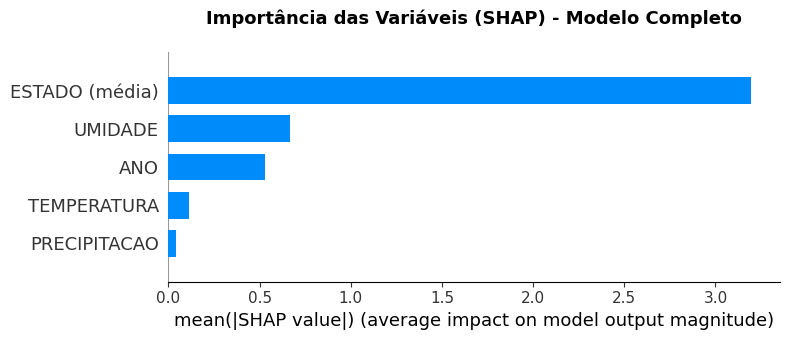

   ✓ Salvo: shap_importance_completo.png


In [20]:
print("\n=== GERANDO VISUALIZAÇÕES ===\n")

# Renomear ESTADO_encoded para melhor visualização
feature_names_display = ['TEMPERATURA', 'UMIDADE', 'PRECIPITACAO', 'ESTADO (média)', 'ANO']
X_display = X_explain_completo.copy()
X_display.columns = feature_names_display

# 5.1 Importância
print("1. Gráfico de Importância...")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_completo, X_display, plot_type="bar", show=False)
plt.title('Importância das Variáveis (SHAP) - Modelo Completo',
         fontsize=13, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_importance_completo.png', dpi=300, bbox_inches='tight')
plt.show()
print("   ✓ Salvo: shap_importance_completo.png")


2. Distribuição dos Efeitos...


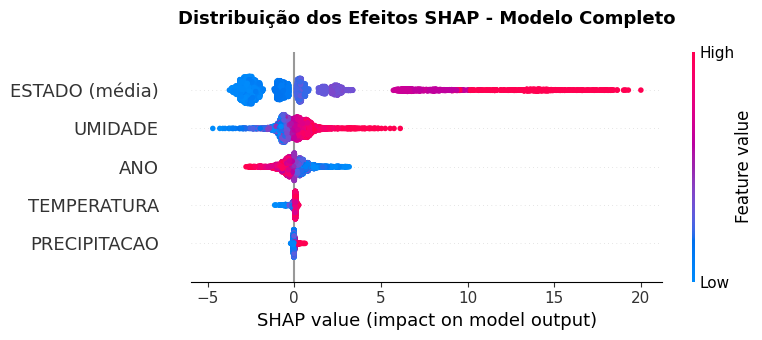

   ✓ Salvo: shap_summary_completo.png


In [21]:
# 5.2 Summary plot
print("\n2. Distribuição dos Efeitos...")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_completo, X_display, show=False)
plt.title('Distribuição dos Efeitos SHAP - Modelo Completo',
         fontsize=13, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_summary_completo.png', dpi=300, bbox_inches='tight')
plt.show()
print("   ✓ Salvo: shap_summary_completo.png")